###### Ruiqi Liu
###### CS6220
###### Assignment 1
###### 1/18/2025

#### Prepare Environment and Load Data

In [15]:
# Import necessary libraries
import pandas as pd
import numpy as np

# Define column names for each file
user_cols = ['user_id', 'gender', 'age', 'occupation', 'zip']
rating_cols = ['user_id', 'movie_id', 'rating', 'timestamp']
movie_cols = ['movie_id', 'title', 'genres']

# Load the data files using pandas read_table
users = pd.read_table('ml-1m/users.dat', sep='::', header=None, names=user_cols, engine='python',encoding='latin-1')
ratings = pd.read_table('ml-1m/ratings.dat', sep='::', header=None, names=rating_cols, engine='python',encoding='latin-1')
movies = pd.read_table('ml-1m/movies.dat', sep='::', header=None, names=movie_cols, engine='python',encoding='latin-1')

# Merge the data into a single DataFrame
data = pd.merge(pd.merge(ratings, users), movies)

# Quick check of the merged data
data.head(1)


,user_id,movie_id,rating,timestamp,gender,age,occupation,zip,title,genres
0,1,1193,5,978300760,F,1,10,48067,One Flew Over the Cuckoo's Nest (1975),Drama


#### Task 1: Aggregate movie ratings by men over age 25 for each genre
1. Filter the data for male users above age 25.
2. Expand the genres column so that each genre is considered separately.
3. Group by each genre and compute aggregate statistics (count and average rating).


In [16]:
# Filter data: only men over age 25
men_over_25 = data[(data.gender == 'M') & (data.age > 25)]

# Split the 'genres' into separate entries
men_over_25_expanded = men_over_25.copy()
men_over_25_expanded['genre_list'] = men_over_25_expanded['genres'].str.split('|')

# Explode the dataframe so each row corresponds to a single genre
men_over_25_expanded = men_over_25_expanded.explode('genre_list')

# Group by each genre and calculate count and mean of ratings
genre_agg = men_over_25_expanded.groupby('genre_list')['rating'].agg(['count', 'mean'])
genre_agg = genre_agg.rename(columns={'count': 'num_ratings', 'mean': 'avg_rating'})

# Sort by number of ratings in descending order and display the result
genre_agg.sort_values(by='num_ratings', ascending=False)


,num_ratings,avg_rating
genre_list,,
Drama,107794,3.812309
Comedy,95836,3.565456
Action,76448,3.554547
Thriller,54883,3.644025
Sci-Fi,49518,3.509693
Adventure,39923,3.538637
Romance,39747,3.659748
War,24391,3.940634
Crime,22545,3.764249


#### Task 2: Top 5 movies by number of ratings
1. Group the data by movie title and count the number of ratings.
2. Sort in descending order and select the top 5 movies.


In [17]:
# Count the number of ratings per movie title
ratings_count = data.groupby('title').size()

# Sort by count in descending order and select top 5 movies
top5_movies = ratings_count.sort_values(ascending=False).head(5)
top5_movies


title
American Beauty (1999)                                   3428
Star Wars: Episode IV - A New Hope (1977)                2991
Star Wars: Episode V - The Empire Strikes Back (1980)    2990
Star Wars: Episode VI - Return of the Jedi (1983)        2883
Jurassic Park (1993)                                     2672
dtype: int64

#### Task 3: Average movie ratings by age groups
Define age groups: `<18`, `18-29`, `30-49`, `50-69`, `70+` and compute the average ratings per group.


In [18]:
# Define bins and labels for age groups
bins = [0, 18, 30, 50, 70, np.inf]  
labels = ['<18', '18-29', '30-49', '50-69', '70+']

# Create an 'age_group' column based on the defined bins
data['age_group'] = pd.cut(data['age'], bins=bins, labels=labels, right=False)

# Group by age_group and calculate mean rating
average_by_age = data.groupby('age_group', observed=False)['rating'].mean()
average_by_age


age_group
<18      3.549520
18-29    3.533299
30-49    3.624050
50-69    3.732677
70+           NaN
Name: rating, dtype: float64

#### Task 4: Unique movies rated by age ranges in the same year as a chosen movie

Steps:
1. Pick a movie (e.g., "Toy Story (1995)") and extract its release year.
2. Add a 'year' column to the dataset extracted from movie titles.
3. Filter movies released in that same year.
4. Define three age ranges: Under 18, 19–45, and Above 45.
5. Group by these age ranges and count the number of unique movies rated.


In [19]:
# Extract year from title using regex and create a new 'year' column
data['year'] = data['title'].str.extract(r'\((\d{4})\)').astype(float)

# Pick a movie and get its year. For example: "Toy Story (1995)"
chosen_movie = "Toy Story (1995)"
chosen_year = data[data.title == chosen_movie]['year'].iloc[0]

# Filter data for movies released in the same year as the chosen movie
same_year_data = data[data.year == chosen_year].copy()

# Define conditions for age ranges
age_range_conditions = [
    (same_year_data.age < 18),
    (same_year_data.age.between(19, 45)),
    (same_year_data.age > 45)
]
age_range_labels = ['Under 18', '19-45', 'Above 45']

# Create an 'age_range' column based on these conditions
same_year_data['age_range'] = np.select(age_range_conditions, age_range_labels)

# Group by age_range and count unique movies rated
unique_movies_by_age = same_year_data.groupby('age_range')['movie_id'].nunique()
unique_movies_by_age


age_range
0           272
19-45       298
Above 45    263
Under 18    198
Name: movie_id, dtype: int64

#### Task 5: Function to find movies rated similarly by a given user
Create a function that, given a user ID and a movie ID, returns a list of other movies that the user rated with the same rating as the specified movie.


In [20]:
def movies_rated_similarly(user_id, movie_id, data):
    """
    For a given user_id and movie_id, return a list of other movie titles 
    that the same user rated with the same rating.
    """
    # Retrieve the rating the user gave to the specified movie
    user_rating = data[(data.user_id == user_id) & (data.movie_id == movie_id)]['rating']
    if user_rating.empty:
        return []  # Return empty list if no such rating exists
    target_rating = user_rating.iloc[0]
    
    # Find all movies rated by the user with the same rating
    similar_ratings = data[(data.user_id == user_id) & (data.rating == target_rating)]
    
    # Exclude the original movie from results
    similar_movies = similar_ratings[similar_ratings.movie_id != movie_id]
    
    # Return unique movie titles from the result
    return similar_movies['title'].unique().tolist()

# Demonstrate the function with an example
example_user = 1
example_movie = 1193  # e.g., "One Flew Over the Cuckoo's Nest (1975)"
similar_movies_list = movies_rated_similarly(example_user, example_movie, data)
similar_movies_list


["Bug's Life, A (1998)",
 'Ben-Hur (1959)',
 'Christmas Story, A (1983)',
 'Beauty and the Beast (1991)',
 'Sound of Music, The (1965)',
 'Awakenings (1990)',
 'Back to the Future (1985)',
 "Schindler's List (1993)",
 'Pocahontas (1995)',
 'Last Days of Disco, The (1998)',
 'Cinderella (1950)',
 'Apollo 13 (1995)',
 'Toy Story (1995)',
 'Rain Man (1988)',
 'Mary Poppins (1964)',
 'Dumbo (1941)',
 'Saving Private Ryan (1998)']

#### Task 6: Additional Statistic or Plot
Exploring how average movie ratings vary by genre and gender, and then plot the results.


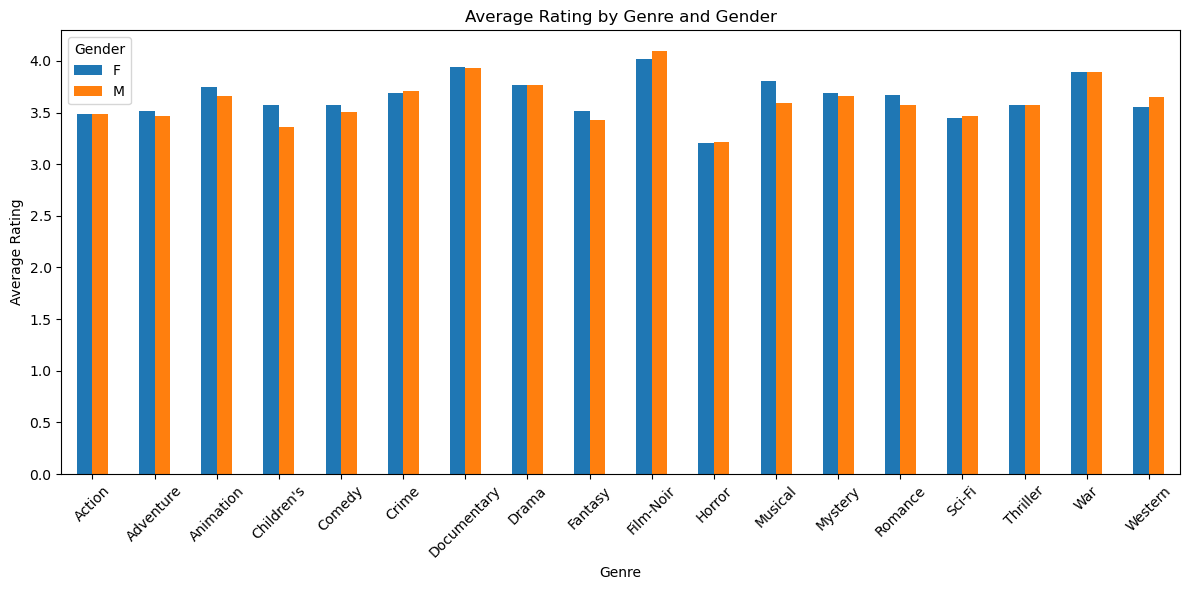

In [21]:
import matplotlib.pyplot as plt

# Expand the dataset to have one row per genre as before
data_expanded = data.copy()
data_expanded['genre_list'] = data_expanded['genres'].str.split('|')
data_expanded = data_expanded.explode('genre_list')

# Compute average rating by genre and gender
genre_gender_avg = data_expanded.groupby(['genre_list', 'gender'])['rating'].mean().unstack()

# Plot the average ratings by genre and gender
genre_gender_avg.plot(kind='bar', figsize=(12,6))
plt.title('Average Rating by Genre and Gender')
plt.xlabel('Genre')
plt.ylabel('Average Rating')
plt.xticks(rotation=45)
plt.legend(title='Gender')
plt.tight_layout()
plt.show()


**Observation:**
- The bar chart shows differences in how different genders rate various genres.
- Only a few certain genres are rated higher by one gender compared to another.
- This insight can be useful for understanding audience preferences and tailoring recommendations.
